# This Jupyter notebook compares results from MPEC and Optimal Solution.

### Here we campare system costs between two methods.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os

## Loading MPEC results for each DA from 'Model_CVS'

In [69]:
print("Loading results from:")
files_path = os.path.realpath(os.path.join(os.path.abspath(''), "Model_CSV"))
print("\t",files_path)
files_name = 'Model_data_DA_'
append_name ="_20221021-185407"
ncda = 9
#Model_data_DA_1_20221021-185407
data = []
for j in range(1,ncda+1):
    path = os.path.join(files_path,files_name+str(j)+append_name+'.csv')
    #print("Reading file {} : {}".format(j,path))
    data.append(pd.read_csv(path))

Loading results from:
	 D:\GitHub\PyomoModels\09_MPEC_Bidding_Diagonalization\MatlabCode\V06\ResultsAnalysis\Model_CSV


## Loading Matlab Linear code results

In [70]:
files_name = 'results_lin_comp_market_10-17-2022@20.41.xlsx'
lin_Competitive_Profit = pd.read_excel(files_name,'Competitive Profit', header=None)

## MPEC PROFIT / SYSTEM-COST: sum(Sell - Buy)*LMPs

In [71]:
da_loc = np.array([[0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0],
[1,1,1,0,0,0,0,0,0],
[0,0,0,1,1,1,0,0,0],
[0,0,0,0,0,0,1,1,1],
[0,0,0,0,0,0,0,0,0]])

bus_col = []
for i in range(1,7):
    bus_col.append('Bus'+str(i)+'_price')

MVA=30

bus_price = data[0][data[0].Iteration==1][bus_col].to_numpy().transpose()

da_sell_list=[]
for df in data:
    da_sell_list.append(df[df.Iteration==1]['DAs_generation\nE_DAs_G'].tolist())

da_buy_list=[]
for df in data:
    da_buy_list.append(df[df.Iteration==1]['DAs_load\nE_DAs_L'].tolist())

da_sell = np.array(da_sell_list)
da_buy  = np.array(da_buy_list)

price_mat = np.matmul(da_loc.T,bus_price)
amount_mat = da_sell*MVA-da_buy*MVA

Mpec_profit = np.multiply(amount_mat, price_mat)

In [72]:
Mpec_df = pd.DataFrame(Mpec_profit)

In [73]:

time_dict = dict(list(enumerate([x for x in range(16,40)])))

def change_time(df):
    for x in range(16,40):
        if x >=24:
            index = df[df['Time'] == x].index
            df.loc[index,'Time'] = df.Time[index]%24
    return df

In [74]:
Mpec_df = Mpec_df.rename(columns=time_dict)
lin_Competitive_Profit = lin_Competitive_Profit.rename(columns=time_dict)

### Compare System Cost (DAs Costs) with Optimal System Costs

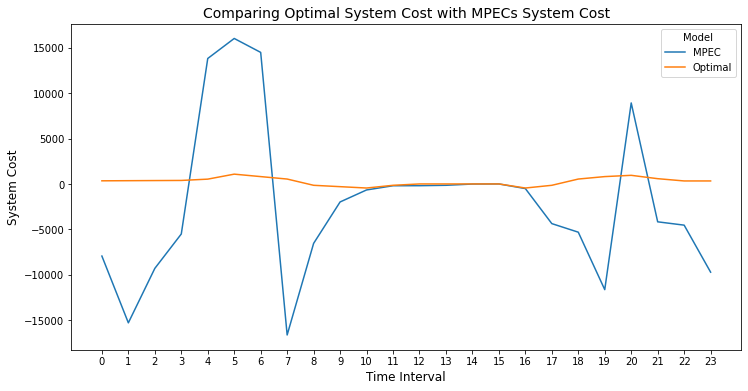

In [85]:
result= dict()
result['MPEC'] = Mpec_df.sum().to_list()
result['Optimal'] = lin_Competitive_Profit.sum().to_list()
result['Time'] = [x for x in range(16,40)]
result_df = pd.DataFrame(result)
result_df = change_time(result_df)
result_df = result_df.melt(id_vars='Time',var_name='Model', value_name='Value')
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

sns.lineplot(data= result_df,  x='Time', y='Value', hue='Model')#hue='category'
axes.set(xticks=[x for x in range(24)]);
axes.set_title("Comparing Optimal System Cost with MPECs System Cost", fontsize=14)
axes.set_xlabel('Time Interval',fontsize=12);
axes.set_ylabel('System Cost',fontsize=12);
fig.savefig("Optimal_vs_MPEC_AVG_System_Cost.png", bbox_inches='tight')

# Result of Total System Cost for EACH Model

In [76]:
result_df.groupby('Model').sum()

,Time,Value
Model,,
MPEC,276,-51514.239109
Optimal,276,6314.264395


The above results shows that generaly, in the MPECs scenarios, total cost value for DAs participants are higher (Minus Value), comparing with optimal model system cost. 

In optimal solution, DAs have profit (Positive Value) from selling excess power.  

In [77]:
cost_mpecs   = result_df.groupby('Model').sum().Value[0]
cost_optimal = result_df.groupby('Model').sum().Value[1]
profit_percentage = abs(cost_optimal - cost_mpecs)/(abs(cost_optimal + cost_mpecs)/2)
print("Percentage of Difference between optimal system cost and MPECs average system cost:",profit_percentage*100,"%")

Percentage of Difference between optimal system cost and MPECs average system cost: 255.87847722874196 %


## Comparing Optimal System Cost with Each DA System Cost

In [82]:
result_df = Mpec_df.copy(deep=True)
result_df['Model'] = 'MPEC'
result_df['DA'] = ['DA'+str(x) for x in range(1,ncda+1)]
result_df.loc[len(result_df.index)] = lin_Competitive_Profit.sum().to_list() + ['Optimal', 'Optimal']

In [83]:
Mpec_df.columns

Int64Index([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
            33, 34, 35, 36, 37, 38, 39],
           dtype='int64')

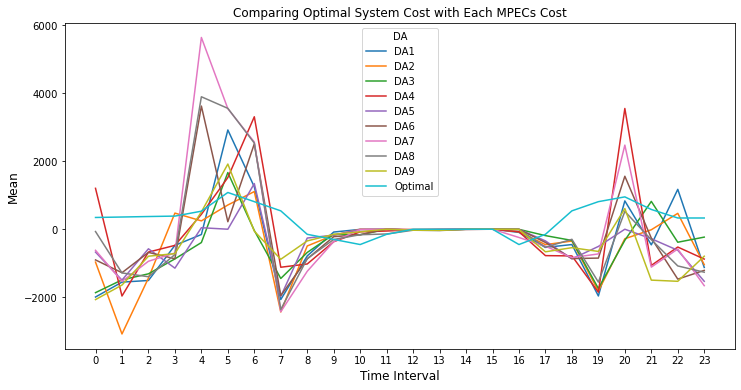

In [84]:
result_df =  result_df.melt(id_vars=['DA','Model'],var_name='Time', value_name='Cost')
result_df = change_time(result_df)
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

sns.lineplot(data= result_df,  x='Time', y='Cost', hue='DA')#hue='category'
axes.set(xticks=[x for x in range(24)]);
axes.set_title("Comparing Optimal System Cost with Each MPECs Cost", fontsize=12)
axes.set_xlabel('Time Interval',fontsize=12);
axes.set_ylabel('Mean',fontsize=12);